# Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
os.chdir("/home2/jgcw74/l3_project")  # go to project root
import importlib

import helpers
import dataset_processing
import models
import xai

torch_device = helpers.utils.get_torch_device()

/home2/jgcw74/l3_project/helpers/ml.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
import typing as t
from pathlib import Path
import json

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
AVAILABLE_MODELS = ("ConvNeXtSmall", "ResNet50", "SwinTransformerSmall")

np.set_printoptions(precision=4, threshold=100, floatmode="fixed", suppress=True)

# Helper functions

In [6]:
def get_dataset_and_model(dataset_n: dataset_processing.DATASET_NAMES, model_n: models.MODEL_NAMES):
    model_type = models.get_model_type(model_n)
    ds = dataset_processing.get_dataset_object(dataset_n, "test", model_type.expected_input_dim, 32, 4, torch_device)

    m = model_type(False, ds.N_BANDS, ds.N_CLASSES).to(torch_device)
    weights_path = json.load(Path("weights_paths.json").open("r"))[dataset_n][model_n]
    m.load_weights(Path("checkpoints") / dataset_n / model_n / weights_path)

    return ds, m

# Figure 1 - Model Randomisation - KPCACAM for ResNet50 on EuroSATMS

In [7]:
dataset_name = "EuroSATMS"
dataset, model = get_dataset_and_model(dataset_name, "ResNet50")
print(list(enumerate(dataset.classes)))

[(0, 'AnnualCrop'), (1, 'Forest'), (2, 'HerbaceousVegetation'), (3, 'Highway'), (4, 'Industrial'), (5, 'Pasture'), (6, 'PermanentCrop'), (7, 'Residential'), (8, 'River'), (9, 'SeaLake')]


In [8]:
class_idx = 8  # "River"
batch_num = 0
kpca_exp = xai.get_explainer_object(
    "KPCACAM", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
kpca_exp.force_load()

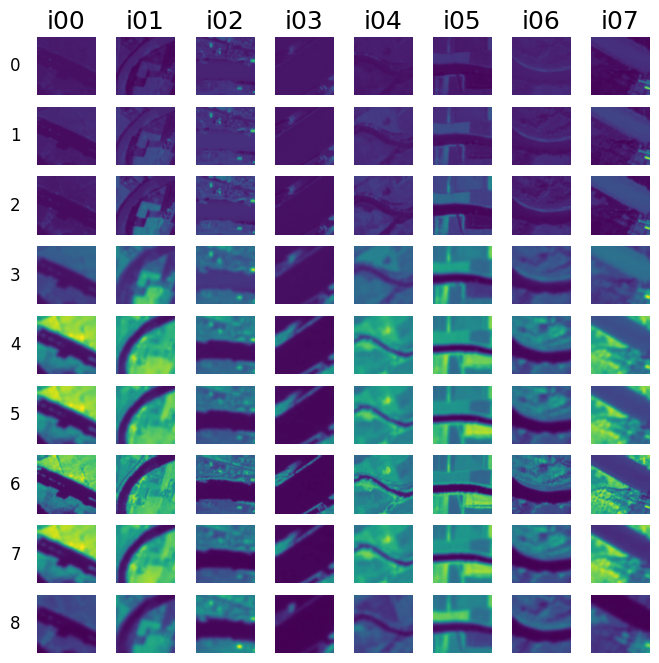

In [10]:
importlib.reload(helpers.plotting)
helpers.plotting.show_image(kpca_exp.input[:8])

PartitionSHAP


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12969846..6.7247224].


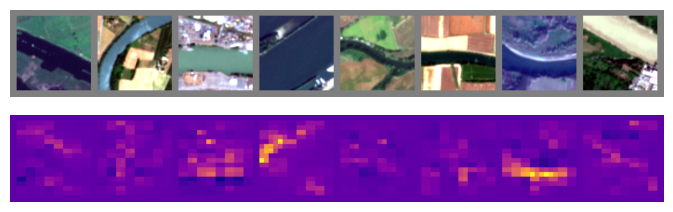

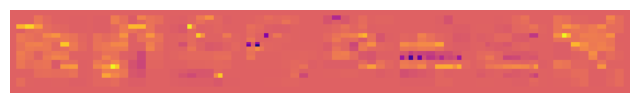

GradCAM


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12969846..6.7247224].


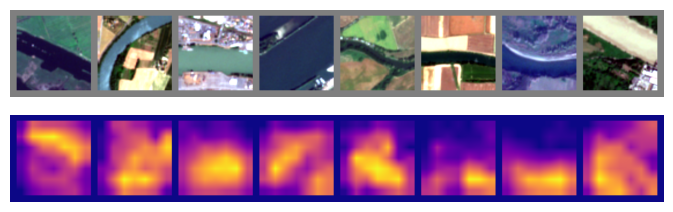

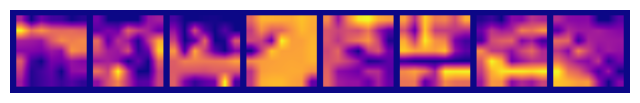

KPCACAM


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12969846..6.7247224].


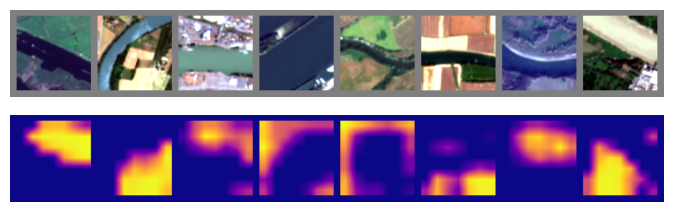

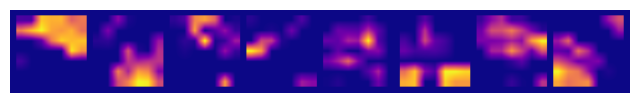

In [10]:
for e_name in t.get_args(xai.EXPLAINER_NAMES):
    print(e_name)

    grad_exp = xai.get_explainer_object(
        e_name, model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
    )
    grad_exp.force_load()
    helpers.plotting.visualise_importance(grad_exp.input[:8, [2,1,0]],
                                          grad_exp.explanation[:8], alpha=0.5, final_fig_size=(10, 2.5),
                                          with_colorbar=False, band_idxs=dataset.rgb_indices, show_samples_separate=True)
    plt.show()

    randomised_exp = xai.get_explainer_object(
        e_name, model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / "combined" / "randomised",
    )
    randomised_exp.force_load()
    helpers.plotting.visualise_importance(randomised_exp.input[:8].numpy(force=True),
                                          randomised_exp.explanation[:8],
                                          alpha=1., with_colorbar=False, band_idxs=dataset.rgb_indices)
    plt.show()

KPCACAM shows extremely similar explanations for the randomised model to those provided for the un-randomised model.

# Figure 2 - AuC - GradCAM is worse than random at identifying relevant pixels for PatternNet.River

In [17]:
dataset_name = "PatternNet"
dataset, model = get_dataset_and_model(dataset_name, "ConvNeXtSmall")
print(list(enumerate(dataset.classes)))

[(0, 'airplane'), (1, 'baseball_field'), (2, 'basketball_court'), (3, 'beach'), (4, 'bridge'), (5, 'cemetery'), (6, 'chaparral'), (7, 'christmas_tree_farm'), (8, 'closed_road'), (9, 'coastal_mansion'), (10, 'crosswalk'), (11, 'dense_residential'), (12, 'ferry_terminal'), (13, 'football_field'), (14, 'forest'), (15, 'freeway'), (16, 'golf_course'), (17, 'harbor'), (18, 'intersection'), (19, 'mobile_home_park'), (20, 'nursing_home'), (21, 'oil_gas_field'), (22, 'oil_well'), (23, 'overpass'), (24, 'parking_lot'), (25, 'parking_space'), (26, 'railway'), (27, 'river'), (28, 'runway'), (29, 'runway_marking'), (30, 'shipping_yard'), (31, 'solar_panel'), (32, 'sparse_residential'), (33, 'storage_tank'), (34, 'swimming_pool'), (35, 'tennis_court'), (36, 'transformer_station'), (37, 'wastewater_treatment_plant')]


In [28]:
class_idx = 27  # "River"
batch_num = 1
shap_exp = xai.get_explainer_object(
    "PartitionSHAP", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
shap_exp.force_load()

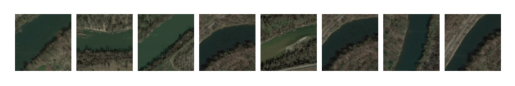

In [29]:
helpers.plotting.show_image(shap_exp.input[:8], padding=20, padding_value=1)

GradCAM


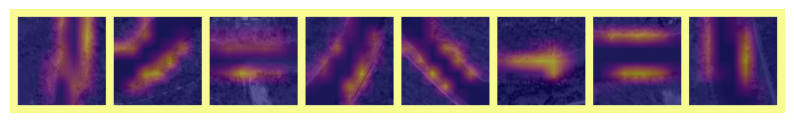

KPCACAM


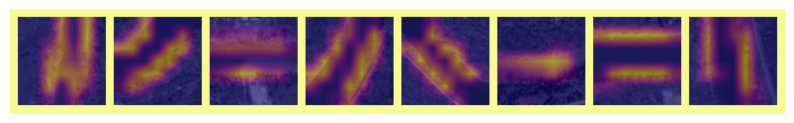

In [20]:
for e_name in ("GradCAM", "KPCACAM"):
    print(e_name)

    grad_exp = xai.get_explainer_object(
        e_name, model,
        extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
    )
    grad_exp.force_load()
    helpers.plotting.visualise_importance(grad_exp.input[:8], grad_exp.explanation[:8],
                                          alpha=0.5, final_fig_size=(10, 2.2), padding_value=1,
                                          with_colorbar=False, band_idxs=dataset.rgb_indices, show_samples_separate=False)
    plt.show()

In [26]:
from evaluate_xai import correctness
importlib.reload(correctness)

<module 'evaluate_xai.correctness' from '/home2/jgcw74/l3_project/evaluate_xai/correctness.py'>

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920928955078125e-07..0.9374364912509918].


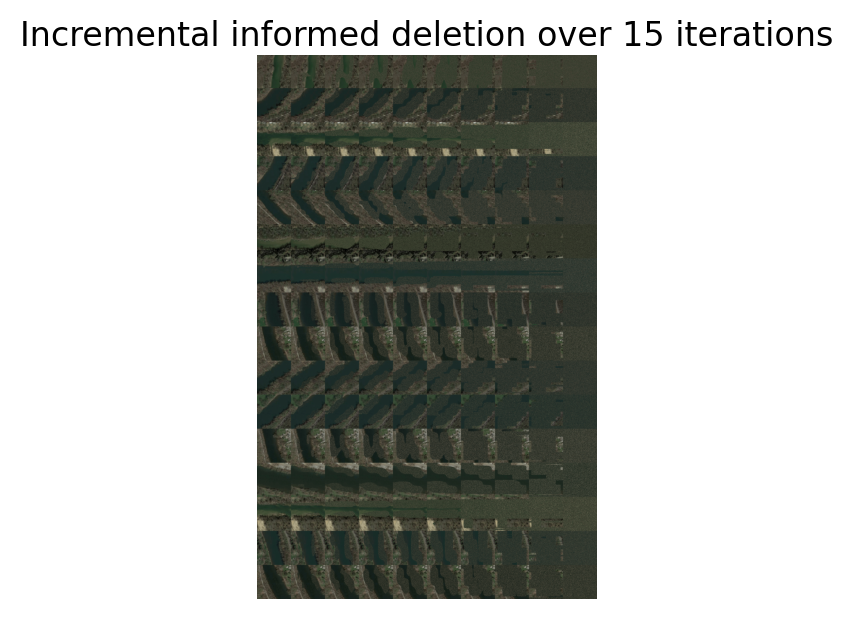

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

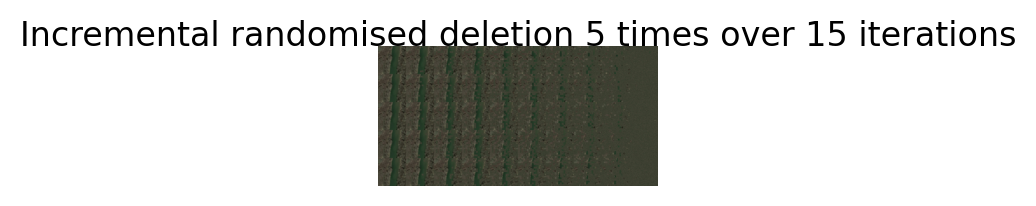

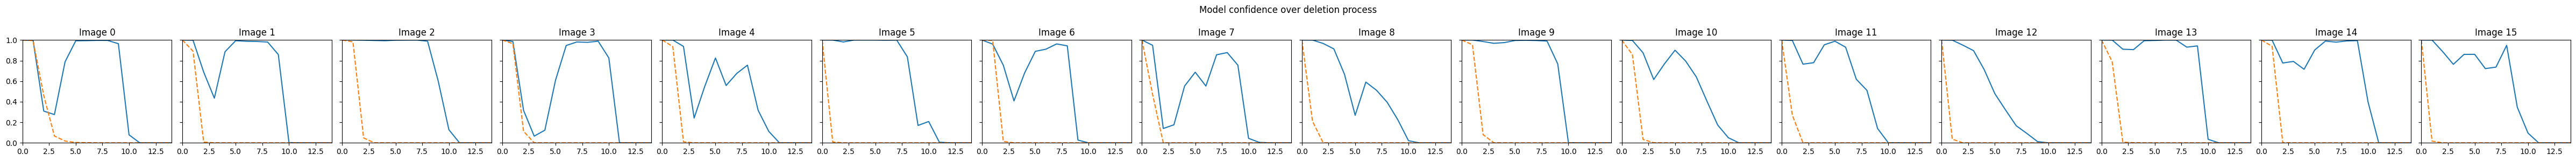

{'informed': array([7.889232 , 8.315438 , 9.199526 , 7.320862 , 6.4724507, 8.697521 ,
        7.036832 , 6.093528 , 6.0566053, 9.175697 , 6.718219 , 7.183568 ,
        5.1246767, 9.213384 , 9.038432 , 7.71894  ], dtype=float32),
 'random': array([2.0446095 , 1.3995178 , 1.5299953 , 1.5775874 , 1.447079  ,
        0.5079646 , 1.5111916 , 0.9709652 , 0.70942163, 1.5350572 ,
        1.3930287 , 0.7699384 , 0.536021  , 1.2982152 , 1.4411395 ,
        0.5168414 ], dtype=float32)}

In [27]:
cor_metric = correctness.Correctness(grad_exp, max_batch_size=8)
aocs = cor_metric.evaluate("incremental_deletion", deletion_method="shuffle", visualise=True)
print(np.mean(aocs["informed"] / aocs["random"]))

NB: it does kind of look more like an in-distribution river image again once there have been enough deletions (on both sides of the river bank). A sign that this metric maybe isn't the most suited to satellite imagery where large areas are important. In this case, it *has* successfully identified pixels; it's just that 'deleting' them has inadvertently led to a river-like image again.

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

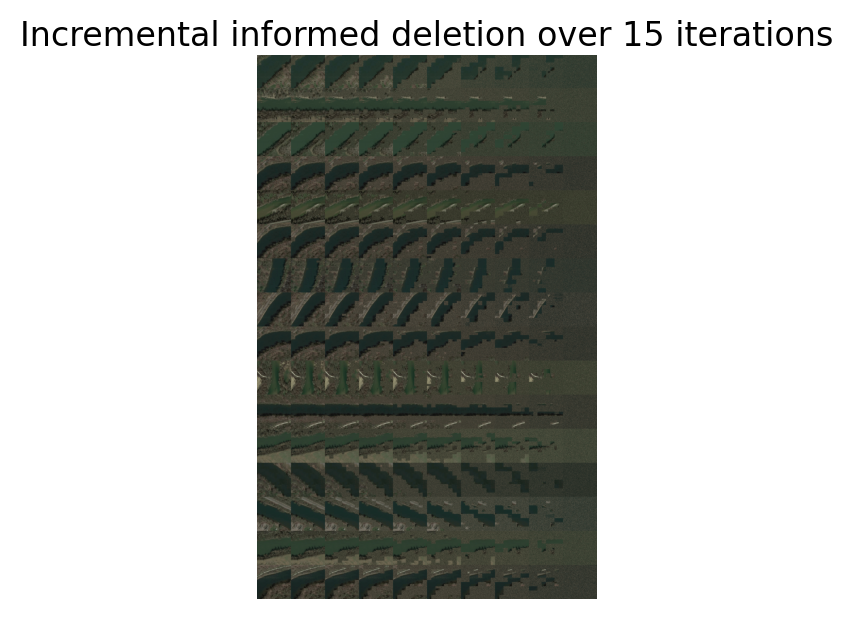

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

Deleting important pixels:   0%|                                                       | 0/15 [00:00<?, ?it/s]

Predicting for Correctness:   0%|                                                   | 0/30 [00:00<?, ?batch/s]

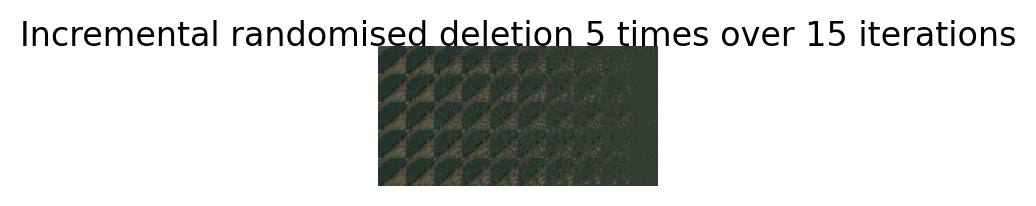

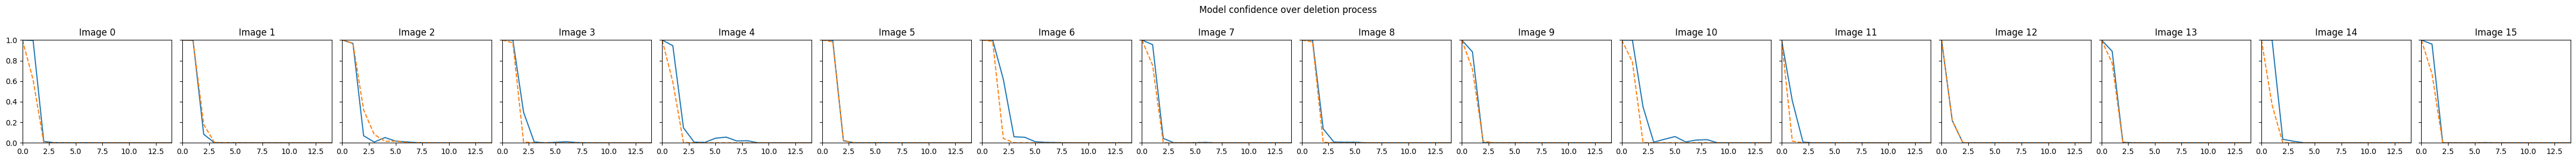

{'informed': array([1.5145712 , 1.5872896 , 1.6240871 , 1.8280078 , 1.7417349 ,
        1.5229961 , 2.2501907 , 1.505537  , 1.6585968 , 1.3872111 ,
        2.0174916 , 0.91820884, 0.71815497, 1.3975527 , 1.5515685 ,
        1.4651245 ], dtype=float32),
 'random': array([1.1135542 , 1.6833172 , 1.9064397 , 1.4811659 , 1.0959146 ,
        1.501445  , 1.5304075 , 1.2562159 , 1.4865546 , 1.23411   ,
        1.290525  , 0.51651406, 0.7164993 , 1.2772037 , 0.8699204 ,
        1.1715893 ], dtype=float32)}

In [30]:
cor_metric2 = correctness.Correctness(shap_exp, max_batch_size=8)
aocs2 = cor_metric2.evaluate("incremental_deletion", deletion_method="shuffle", visualise=True)
print(np.mean(aocs2["informed"] / aocs2["random"]))

While the above is true, PartitionSHAP still manages to better on the same class of images so clearly it has identified the important locations better? PartitionSHAP is roughly on par with random.

# Figure 3 - Deletion/Preservation checks - Efficacy of deletion and preservation checks on UCMerced.Sparse Residential

In [17]:
from evaluate_xai import output_completeness

In [32]:
dataset_name = "UCMerced"
dataset, model = get_dataset_and_model(dataset_name, "ConvNeXtSmall")
print(list(enumerate(dataset.classes)))

[(0, 'agricultural'), (1, 'airplane'), (2, 'baseballdiamond'), (3, 'beach'), (4, 'buildings'), (5, 'chaparral'), (6, 'denseresidential'), (7, 'forest'), (8, 'freeway'), (9, 'golfcourse'), (10, 'harbor'), (11, 'intersection'), (12, 'mediumresidential'), (13, 'mobilehomepark'), (14, 'overpass'), (15, 'parkinglot'), (16, 'river'), (17, 'runway'), (18, 'sparseresidential'), (19, 'storagetanks'), (20, 'tenniscourt')]


In [36]:
class_idx = 18  # "sparse residential"
batch_num = 0
grad_ucm_sr_exp = xai.get_explainer_object(
    "GradCAM", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
grad_ucm_sr_exp.force_load()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


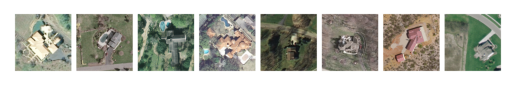

In [37]:
helpers.plotting.show_image(grad_ucm_sr_exp.input[:8], padding=20, padding_value=1)

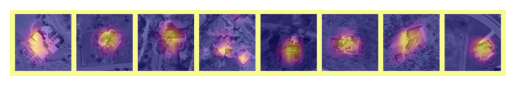

In [38]:
helpers.plotting.visualise_importance(grad_ucm_sr_exp.input[:8], grad_ucm_sr_exp.explanation[:8],
                                      alpha=0.5, padding_value=1, with_colorbar=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


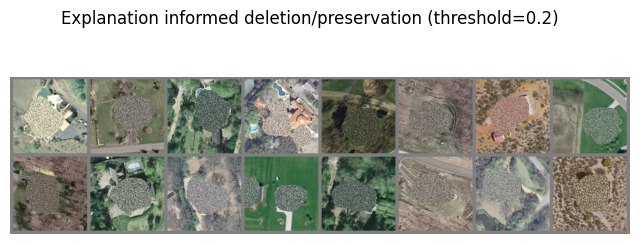

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001192092896].


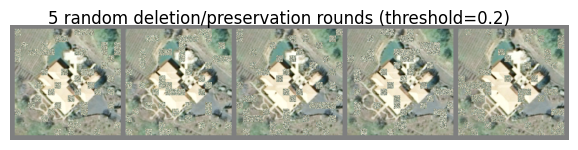

Predicting for OutputCompleteness:   0%|                                            | 0/14 [00:00<?, ?batch/s]

Original predictions: [18 18 18 12 18 18 18 18 18 18 18 18 18 18 18 18]
Confidence after informed: [0.9999 0.0017 0.8114 0.0002 0.0054 0.0044 1.0000 0.0005 0.0899 0.9986
 0.3567 0.0000 0.5440 0.2568 0.0001 0.9996]
Confidence after random: [1.0000 1.0000 0.9983 0.9648 0.9941 1.0000 1.0000 1.0000 1.0000 0.9993
 1.0000 1.0000 1.0000 1.0000 0.9801 1.0000]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


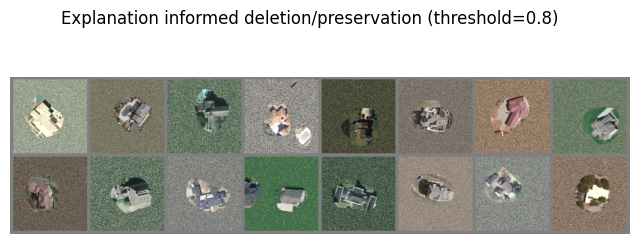

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001192092896].


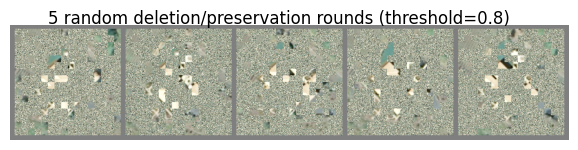

Predicting for OutputCompleteness:   0%|                                            | 0/14 [00:00<?, ?batch/s]

Original predictions: [18 18 18 12 18 18 18 18 18 18 18 18 18 18 18 18]
Confidence after informed: [1.0000 1.0000 1.0000 0.0042 0.9999 1.0000 1.0000 1.0000 1.0000 1.0000
 1.0000 1.0000 1.0000 1.0000 1.0000 0.9999]
Confidence after random: [0.1201 0.0144 0.0019 0.2259 0.0002 0.0112 0.0021 0.0001 0.0134 0.0152
 0.0640 0.0001 0.0051 0.1523 0.0105 0.1767]
0.6167069 0.8869264


In [51]:
ocd_metric = output_completeness.OutputCompleteness(grad_ucm_sr_exp, max_batch_size=8)
del_check = ocd_metric.evaluate("deletion_check", deletion_method="shuffle", threshold=0.2, visualise=True)
pres_check = ocd_metric.evaluate("preservation_check", deletion_method="shuffle", threshold=0.2, visualise=True)
print(del_check.mean(), pres_check.mean())

## PatternNet.Freeway

In [82]:
dataset_name = "PatternNet"
dataset, model = get_dataset_and_model(dataset_name, "ConvNeXtSmall")
print(list(enumerate(dataset.classes)))

[(0, 'airplane'), (1, 'baseball_field'), (2, 'basketball_court'), (3, 'beach'), (4, 'bridge'), (5, 'cemetery'), (6, 'chaparral'), (7, 'christmas_tree_farm'), (8, 'closed_road'), (9, 'coastal_mansion'), (10, 'crosswalk'), (11, 'dense_residential'), (12, 'ferry_terminal'), (13, 'football_field'), (14, 'forest'), (15, 'freeway'), (16, 'golf_course'), (17, 'harbor'), (18, 'intersection'), (19, 'mobile_home_park'), (20, 'nursing_home'), (21, 'oil_gas_field'), (22, 'oil_well'), (23, 'overpass'), (24, 'parking_lot'), (25, 'parking_space'), (26, 'railway'), (27, 'river'), (28, 'runway'), (29, 'runway_marking'), (30, 'shipping_yard'), (31, 'solar_panel'), (32, 'sparse_residential'), (33, 'storage_tank'), (34, 'swimming_pool'), (35, 'tennis_court'), (36, 'transformer_station'), (37, 'wastewater_treatment_plant')]


In [83]:
class_idx = 15  # "freeway"
batch_num = 1
kpca_pn_fw_exp = xai.get_explainer_object(
    "KPCACAM", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
kpca_pn_fw_exp.force_load()

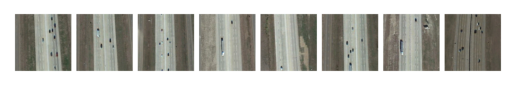

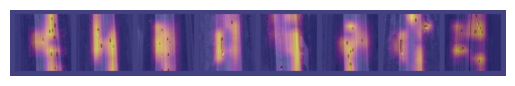

In [84]:
helpers.plotting.show_image(kpca_pn_fw_exp.input[:8], padding=20, padding_value=1)
plt.show()
helpers.plotting.visualise_importance(kpca_pn_fw_exp.input[:8], kpca_pn_fw_exp.explanation[:8],
                                      alpha=0.5, padding_value=0, with_colorbar=False)

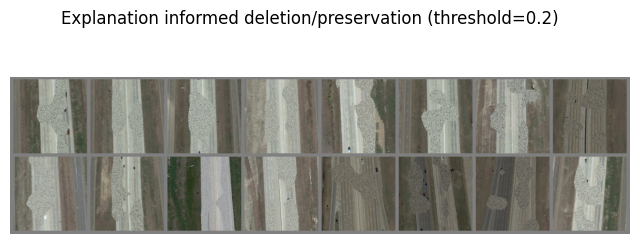

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

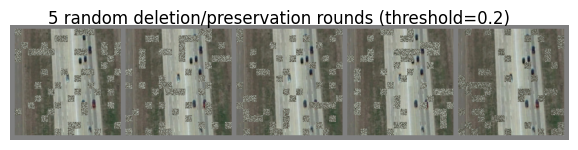

Predicting for OutputCompleteness:   0%|                                            | 0/14 [00:00<?, ?batch/s]

Original predictions: [15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]
Confidence after informed: [0.0002 0.0000 0.0005 0.0000 0.0079 0.0024 0.0000 0.0000 0.0140 0.0001
 0.0000 0.0000 0.0002 0.0000 0.0000 0.0000]
Confidence after random: [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]


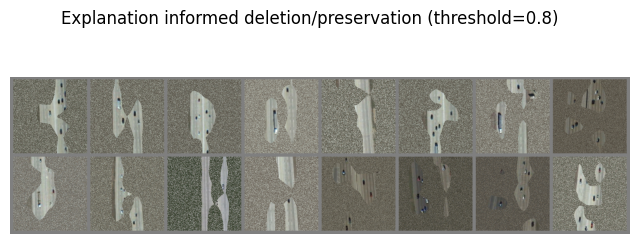

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

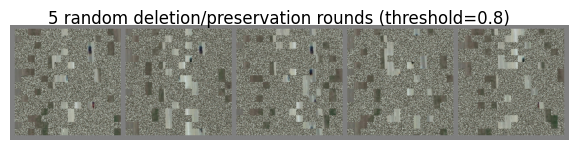

Predicting for OutputCompleteness:   0%|                                            | 0/14 [00:00<?, ?batch/s]

Original predictions: [15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]
Confidence after informed: [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 0.0056 0.0000]
Confidence after random: [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
-0.0015775126 0.00034969466


In [73]:
ocd_metric = output_completeness.OutputCompleteness(kpca_pn_fw_exp, max_batch_size=8)
del_check = ocd_metric.evaluate("deletion_check", deletion_method="shuffle", threshold=0.2, visualise=True)
pres_check = ocd_metric.evaluate("preservation_check", deletion_method="shuffle", threshold=0.2, visualise=True)
print(del_check.mean(), pres_check.mean())

For this class, the model is super sensitive to any changes to the input image it appears so informed and random deletion are on par. This is an excellent example of why you have to compare to random deletion to see if the explanation is good or the model is just sensitive.

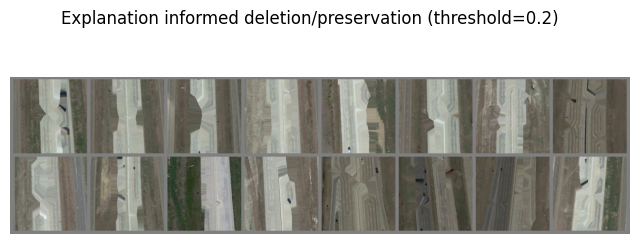

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

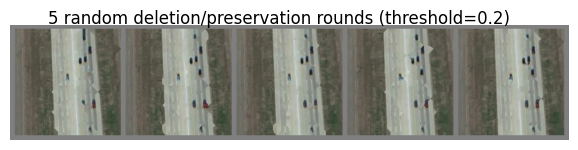

Predicting for OutputCompleteness:   0%|                                            | 0/14 [00:00<?, ?batch/s]

Original predictions: [15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]
Confidence after informed: [0.9987 0.9933 0.9996 0.9999 0.9988 1.0000 0.8895 0.0164 0.9681 1.0000
 0.9995 0.9999 0.7790 0.9998 0.4588 1.0000]
Confidence after random: [1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000]


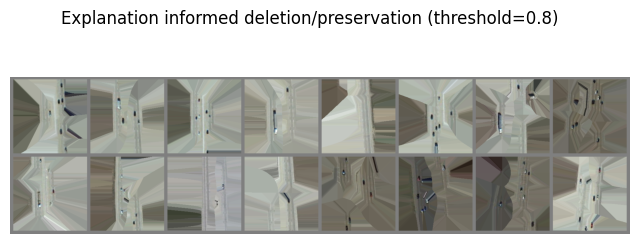

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

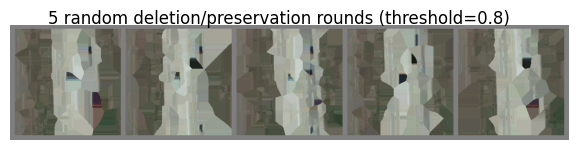

Predicting for OutputCompleteness:   0%|                                            | 0/14 [00:00<?, ?batch/s]

Original predictions: [15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]
Confidence after informed: [0.0965 0.9320 0.0395 0.7722 0.4761 0.9126 0.0042 0.3702 0.0004 0.9932
 0.9944 0.0019 0.0034 0.0666 0.5995 0.0948]
Confidence after random: [1.0000 1.0000 0.7993 0.9412 0.4948 0.9761 0.7044 0.9983 0.8916 0.9966
 0.8334 0.7597 0.8030 0.8517 0.7037 0.9996]
0.11866933 -0.46222663


In [74]:
ocd_metric = output_completeness.OutputCompleteness(kpca_pn_fw_exp, max_batch_size=8)
del_check = ocd_metric.evaluate("deletion_check", deletion_method="nn", threshold=0.2, visualise=True)
pres_check = ocd_metric.evaluate("preservation_check", deletion_method="nn", threshold=0.2, visualise=True)
print(del_check.mean(), pres_check.mean())

Note how different these results are when using a different deletion method, especially for preservation.

## EuroSAT.Highway

In [85]:
dataset_name = "EuroSATRGB"
dataset, model = get_dataset_and_model(dataset_name, "ConvNeXtSmall")
print(list(enumerate(dataset.classes)))

[(0, 'AnnualCrop'), (1, 'Forest'), (2, 'HerbaceousVegetation'), (3, 'Highway'), (4, 'Industrial'), (5, 'Pasture'), (6, 'PermanentCrop'), (7, 'Residential'), (8, 'River'), (9, 'SeaLake')]


In [86]:
class_idx = 3  # "highway"
batch_num = 1
kpca_er_hw_exp = xai.get_explainer_object(
    "KPCACAM", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
kpca_er_hw_exp.force_load()

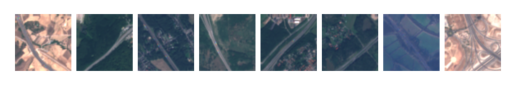

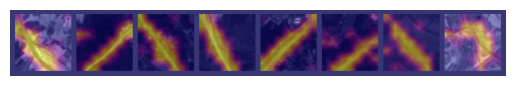

In [87]:
helpers.plotting.show_image(kpca_er_hw_exp.input[:8], padding=20, padding_value=1)
plt.show()
helpers.plotting.visualise_importance(kpca_er_hw_exp.input[:8], kpca_er_hw_exp.explanation[:8],
                                      alpha=0.5, padding_value=0, with_colorbar=False)

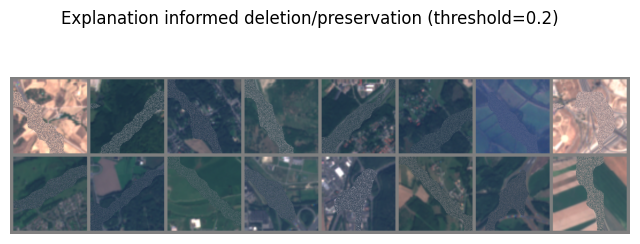

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

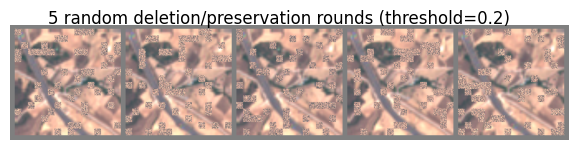

Predicting for OutputCompleteness:   0%|                                            | 0/14 [00:00<?, ?batch/s]

Original predictions: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Confidence after informed: [0.0000 0.0000 0.0437 0.0000 0.0000 0.0000 0.0000 0.0008 0.0000 0.0001
 0.0009 0.0000 0.0000 0.0000 0.9940 0.9041]
Confidence after random: [1.0000 0.9951 1.0000 1.0000 1.0000 0.9988 0.8057 0.5210 0.7989 0.9996
 1.0000 0.8491 0.1897 1.0000 1.0000 1.0000]


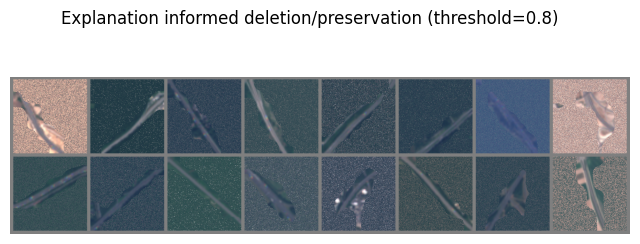

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

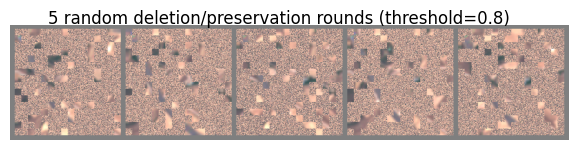

Predicting for OutputCompleteness:   0%|                                            | 0/14 [00:00<?, ?batch/s]

Original predictions: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Confidence after informed: [1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 0.9967 0.0003 1.0000 1.0000
 1.0000 1.0000 0.5708 1.0000 1.0000 1.0000]
Confidence after random: [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
 0.0037 0.0000 0.0000 0.0000 0.0000 0.0000]
0.76339257 0.91025543


In [88]:
ocd_metric = output_completeness.OutputCompleteness(kpca_er_hw_exp, max_batch_size=8)
del_check = ocd_metric.evaluate("deletion_check", deletion_method="shuffle", threshold=0.2, visualise=True)
pres_check = ocd_metric.evaluate("preservation_check", deletion_method="shuffle", threshold=0.2, visualise=True)
print(del_check.mean(), pres_check.mean())

## Good vs poor explainer: UCMerced Mobile Home by KPCA vs PartitionSHAP

In [99]:
dataset_name = "UCMerced"
dataset, model = get_dataset_and_model(dataset_name, "ResNet50")
print(list(enumerate(dataset.classes)))

[(0, 'agricultural'), (1, 'airplane'), (2, 'baseballdiamond'), (3, 'beach'), (4, 'buildings'), (5, 'chaparral'), (6, 'denseresidential'), (7, 'forest'), (8, 'freeway'), (9, 'golfcourse'), (10, 'harbor'), (11, 'intersection'), (12, 'mediumresidential'), (13, 'mobilehomepark'), (14, 'overpass'), (15, 'parkinglot'), (16, 'river'), (17, 'runway'), (18, 'sparseresidential'), (19, 'storagetanks'), (20, 'tenniscourt')]


In [100]:
class_idx = 13  # "mobilehomepark"
batch_num = 0
kpca_bad_exp = xai.get_explainer_object(
    "KPCACAM", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
kpca_bad_exp.force_load()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0000001].


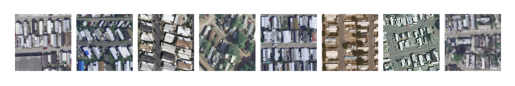

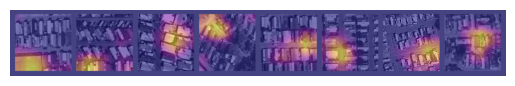

In [101]:
helpers.plotting.show_image(kpca_bad_exp.input[:8], padding=20, padding_value=1)
plt.show()
helpers.plotting.visualise_importance(kpca_bad_exp.input[:8], kpca_bad_exp.explanation[:8],
                                      alpha=0.5, padding_value=0, with_colorbar=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0000001].


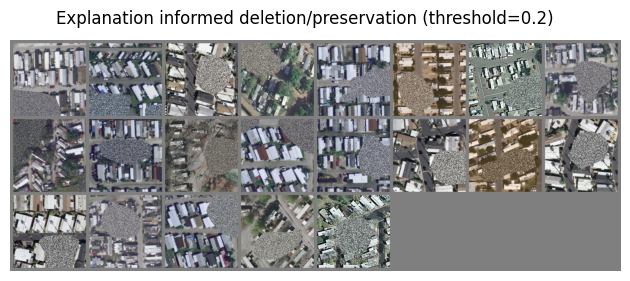

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

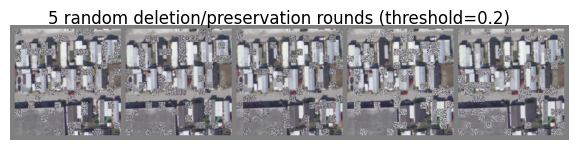

Predicting for OutputCompleteness:   0%|                                            | 0/19 [00:00<?, ?batch/s]

Original predictions: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
Confidence after informed: [0.9188 0.9880 0.5110 0.9920 0.4695 0.9088 0.9823 0.1498 0.9956 0.9562
 0.0030 0.9964 0.9219 0.1252 0.8803 0.5214 0.1701 0.9575 0.9950 0.5056
 0.9899]
Confidence after random: [0.1584 0.5661 0.0250 0.1800 0.1890 0.0060 0.3238 0.0722 0.0222 0.0922
 0.0120 0.1914 0.1889 0.0249 0.0529 0.0105 0.1364 0.0179 0.4789 0.2156
 0.1291]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0000001].


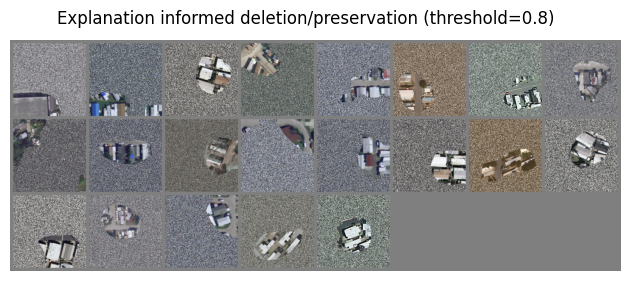

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

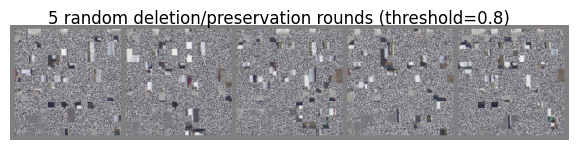

Predicting for OutputCompleteness:   0%|                                            | 0/19 [00:00<?, ?batch/s]

Original predictions: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
Confidence after informed: [0.0004 0.3363 0.0061 0.0013 0.0037 0.0004 0.0455 0.0020 0.0000 0.0002
 0.0056 0.0002 0.0020 0.0171 0.0018 0.0151 0.0180 0.0014 0.0024 0.1661
 0.1075]
Confidence after random: [0.0005 0.0005 0.0002 0.0002 0.0011 0.0000 0.0003 0.0002 0.0002 0.0014
 0.0000 0.0004 0.0011 0.0003 0.0000 0.0001 0.0001 0.0002 0.0005 0.0001
 0.0001]
-0.5640481 0.03455822


In [102]:
ocd_metric = output_completeness.OutputCompleteness(kpca_bad_exp, max_batch_size=8)
del_check = ocd_metric.evaluate("deletion_check", deletion_method="shuffle", threshold=0.2, visualise=True)
pres_check = ocd_metric.evaluate("preservation_check", deletion_method="shuffle", threshold=0.2, visualise=True)
print(del_check.mean(), pres_check.mean())

The deletion of KPCACAM is far worse than random - it's not really reflecting the model's reasoning at all.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0000001].


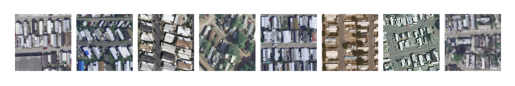

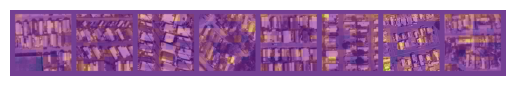

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0000001].


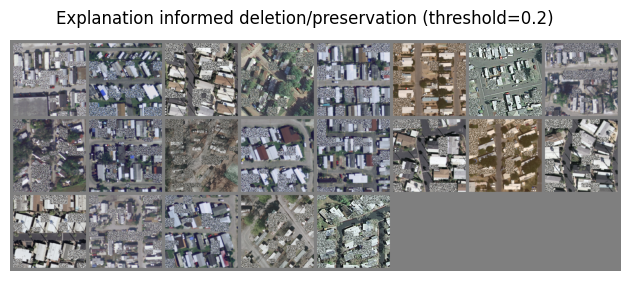

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

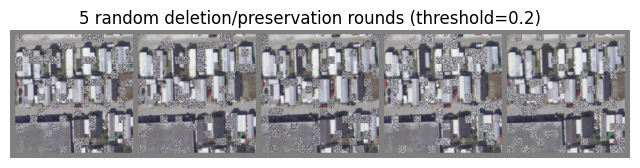

Predicting for OutputCompleteness:   0%|                                            | 0/19 [00:00<?, ?batch/s]

Original predictions: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
Confidence after informed: [0.0333 0.4878 0.0017 0.1216 0.0627 0.2643 0.0359 0.0922 0.0033 0.1511
 0.0001 0.0442 0.5258 0.0003 0.0067 0.0002 0.0153 0.0626 0.1898 0.0578
 0.0171]
Confidence after random: [0.2303 0.6155 0.0165 0.1710 0.1559 0.0092 0.4027 0.0613 0.0206 0.0909
 0.0124 0.1791 0.1700 0.0201 0.0830 0.0125 0.1482 0.0130 0.4641 0.2385
 0.0875]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0000001].


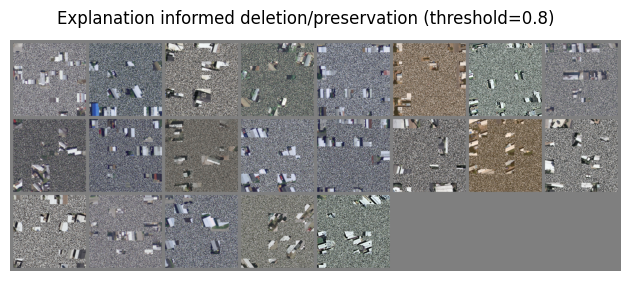

Randomly perturbing:   0%|                                                              | 0/5 [00:00<?, ?it/s]

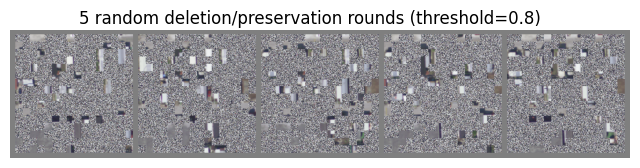

Predicting for OutputCompleteness:   0%|                                            | 0/19 [00:00<?, ?batch/s]

Original predictions: [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
Confidence after informed: [0.0022 0.0024 0.0017 0.0026 0.0013 0.0004 0.0223 0.0019 0.0007 0.0024
 0.0001 0.0045 0.0099 0.0010 0.0015 0.0004 0.0029 0.0008 0.0017 0.0008
 0.0040]
Confidence after random: [0.0003 0.0004 0.0001 0.0002 0.0012 0.0000 0.0002 0.0003 0.0002 0.0012
 0.0000 0.0005 0.0010 0.0003 0.0000 0.0001 0.0002 0.0002 0.0004 0.0001
 0.0001]
0.048972696 0.0027747029


In [104]:
ps_good_exp = xai.get_explainer_object(
    "PartitionSHAP", model,
    extra_path=Path(dataset_name) / f"c{class_idx:02}" / f"b{batch_num:03}",
)
ps_good_exp.force_load()
helpers.plotting.show_image(ps_good_exp.input[:8], padding=20, padding_value=1)
plt.show()
helpers.plotting.visualise_importance(ps_good_exp.input[:8], ps_good_exp.explanation[:8],
                                      alpha=0.5, padding_value=0, with_colorbar=False)
plt.show()
ocd_metric = output_completeness.OutputCompleteness(ps_good_exp, max_batch_size=8)
del_check = ocd_metric.evaluate("deletion_check", deletion_method="shuffle", threshold=0.2, visualise=True)
pres_check = ocd_metric.evaluate("preservation_check", deletion_method="shuffle", threshold=0.2, visualise=True)
print(del_check.mean(), pres_check.mean())

PartitionSHAP also struggles to be much better than random but is at least positive...
It performs worse at preservation though.

# Figure 4 - Contrastivity -